In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import os
import numpy as np
from tqdm import tqdm
import logging
from gym.wrappers import RecordVideo
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.Agent import DQAgent

In [3]:
!mkdir logs
logging.basicConfig(filename='logs/lunar-lander.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


In [4]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power =15.0,
    turbulence_power=1.5,
    render_mode = "rgb_array"
)

In [5]:
state, info = env.reset()
img = env.render()

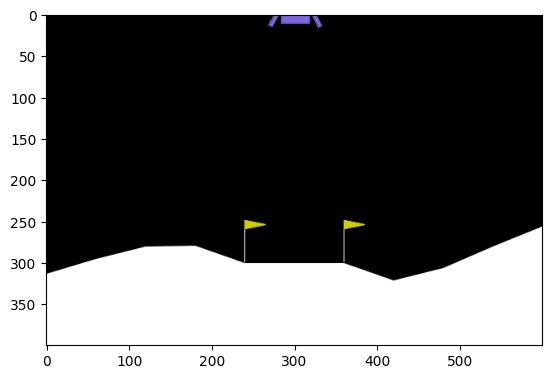

In [6]:
plt.imshow(img)

In [7]:
episodes = 500
agent = DQAgent(
    n_observations=8,
    n_actions= 4,
    device= "cuda" if torch.cuda.is_available() else "cpu"
)
history = []
losses = []
rewards = []

best_model = None
best_reward = -np.inf
for e in tqdm(range(episodes)):

    state, _ = env.reset()
    count = 0
    epoch_reward = [] 
    loss_epoch = [ ]
    # Play the game!
    while True:
        count += 1
        # Run agent on the state
        
        action = agent.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        epoch_reward.append(reward)
        
        if done or trunc:
            next_state = None
        # Remember
        agent.save_to_memory(state, next_state, action, reward,)

        # Learn
        loss = agent.learn()
        if loss is not None: 
            loss_epoch.append(loss.item())


        # # Loggings
        # logging.info(loss)

        agent.update_networks()

        # Update state
        state = next_state

        # Check if end of game
        if done or trunc:
            rewards.append(np.sum(epoch_reward))
            losses.append(np.mean(loss_epoch))
            if np.mean(epoch_reward) > best_reward:
                best_reward = np.mean(epoch_reward)
                best_model = deepcopy(agent.policy_dqn)

            logging.info(f"Game ended after {count} ticks")
            count = 0
            break

  0%|          | 0/500 [00:00<?, ?it/s]/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


In [20]:
agent.policy_dqn = best_model

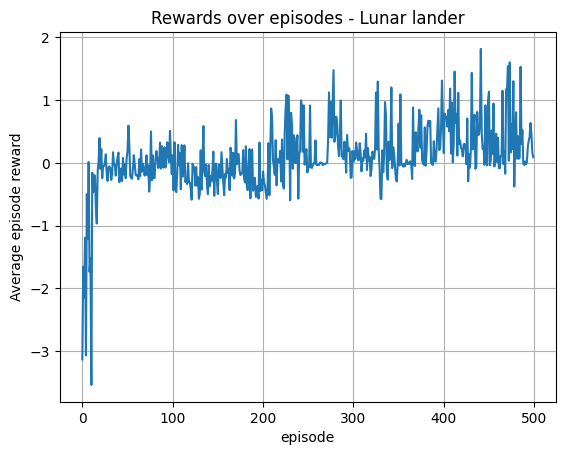

In [16]:
plt.plot(rewards)
plt.grid()
plt.ylabel("Average episode reward")
plt.xlabel("episode")
plt.title("Rewards over episodes - Lunar lander")

plt.savefig("img/lunar-lander-reward.png")

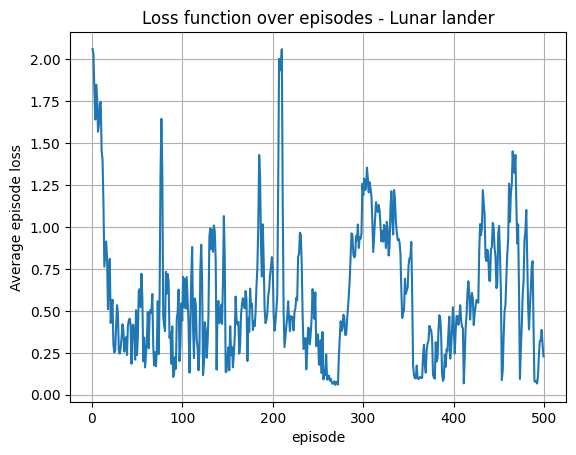

In [17]:

plt.grid()
plt.title("Loss function over episodes - Lunar lander")
plt.ylabel("Average episode loss")
plt.xlabel("episode")
plt.plot(losses)

plt.savefig("img/lunar-lander-loss.png")

In [18]:
env_video = RecordVideo(gym.make(
    "LunarLander-v2",
        continuous = False,
        gravity = -10.0,
        enable_wind = False,
        wind_power =15.0,
        turbulence_power=1.5,
        render_mode = "rgb_array"
    ), 
    "./mp4", 
)

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /users/eleves-a/2022/pedro.silva/Reinforcement-Learning-problems/mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


In [24]:
count = 0
state, _= env_video.reset()
agent.epsilon = 0
rewards = []
while True:
    count += 1
    # Run agent on the state
    
    action = agent.act(state)

    # Agent performs action
    next_state, reward, done, trunc, info = env_video.step(action)

    rewards.append(reward)
    # Update state
    state = next_state

    # Check if end of game
    if done or trunc:
        logging.info(f"Game ended after {count} ticks")
        count = 0
        break

In [29]:
np.sum(rewards)

247.34295992587332